## Imports and Options

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [3]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
%matplotlib inline

In [5]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

## Utility Functions

In [6]:
def training_progress(fitted_model, metrics, num_plots, loss_name, plot_val=None):
    '''
    A function for plotting the model history by showing the metric and loss throughout training
    '''
    plt.subplot(1, num_plots, 2)
    plt.plot(fitted_model.history['loss'], label='train loss')
    if plot_val is not None:
        plt.plot(fitted_model.history['val_loss'], label='val loss')
    plt.title('Loss ({})'.format(loss_name))
    plt.legend()

    for i, metric in enumerate(metrics):
        subplot_number = i + 3
        plt.subplot(1, num_plots, subplot_number)
        plt.plot(fitted_model.history[metric], label=str(metric))
        if plot_val is not None:
            plt.plot(fitted_model.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(str(metric))
        plt.legend()

    plt.show()


def plot_model_result(model, fitted_model, metrics, X, loss_name, plot_val=None):
    '''
    plot the foe_probabilities of a model
    plot the training history
    show training accuracy
    '''
    num_plots = len(metrics) + 2
    probas = model.predict_proba(X)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_plots, 1)
    plt.hist(probas)
    plt.xlabel('predict_proba')
    training_progress(fitted_model, metrics, num_plots, loss_name, plot_val)

## Prepare Data

### Set Features

In [7]:
features = n.morph_cols + ["YL1-A", "YL1-H", "YL1-W"]

In [8]:
features

['FSC-A',
 'FSC-H',
 'FSC-W',
 'SSC-A',
 'SSC-H',
 'SSC-W',
 'YL1-A',
 'YL1-H',
 'YL1-W']

In [35]:
features_2 = n.morph_cols + ["YL1-A", "YL1-H", "YL1-W", n.timepoint]

### Full Data

In [9]:
df_all = pd.read_csv("models/cfu_neural_network/df_for_testing_2.csv")

In [10]:
grouped = df_all.groupby([n.inducer_concentration, n.timepoint])
df_all = grouped.apply(lambda x: x.sample(5000)).reset_index(drop=True)

In [11]:
df_all["arbitrary_index"] = df_all.index

In [12]:
# df_all.groupby([n.inducer_concentration, n.timepoint]).size()

In [13]:
defined_labels_df = df_all.loc[df_all[n.timepoint] == 6.0].copy()

In [14]:
defined_labels_df = defined_labels_df.loc[defined_labels_df[n.inducer_concentration].isin([5.0, 15.0])]

In [15]:
defined_labels_df.loc[defined_labels_df[n.inducer_concentration]==5.0, "label"] = 1.0
defined_labels_df.loc[defined_labels_df[n.inducer_concentration]==15.0, "label"] = 0.0

In [16]:
defined_labels_df

,inducer_concentration,timepoint,BL1-A,BL1-H,BL1-W,BL2-A,BL2-H,BL2-W,BL3-A,BL3-H,BL3-W,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,YL1-A,YL1-H,YL1-W,YL2-A,YL2-H,YL2-W,YL3-A,YL3-H,YL3-W,YL4-A,YL4-H,YL4-W,percent_live,arbitrary_index,label
55000,5.0,6.0,2.42651,2.33846,1.41497,2.02531,2.37658,1.27875,0.00000,2.06446,0.47712,5.36625,5.35844,1.89763,5.29072,5.28352,1.90848,2.85552,2.91645,1.77085,1.90848,2.16137,0.90309,1.63347,2.29447,1.11394,0.00000,1.74819,0.00000,25.956667,55000,1.0
55001,5.0,6.0,2.48001,2.26951,1.39794,1.74819,2.48001,1.43136,2.59879,2.66932,1.66276,5.60311,5.60374,1.91908,5.12448,5.13515,1.91908,0.00000,2.38021,1.43136,0.00000,0.90309,0.00000,0.00000,1.70757,0.00000,2.15534,2.04532,0.47712,25.956667,55001,1.0
55002,5.0,6.0,2.02531,2.44871,1.25527,0.84510,2.28556,1.25527,2.12057,2.48287,1.50515,5.63683,5.62056,1.93952,5.54863,5.53467,1.95424,0.00000,1.79239,0.00000,0.00000,1.69020,0.00000,0.00000,1.72428,0.00000,1.25527,2.01284,0.30103,25.956667,55002,1.0
55003,5.0,6.0,2.42488,2.49415,1.62325,2.76938,2.58659,1.77085,3.05576,2.77670,1.93450,5.78869,5.71754,1.97313,5.63849,5.56374,1.97772,2.15534,2.05690,1.17609,1.50515,1.82607,0.00000,0.00000,1.14613,0.00000,2.28780,2.07918,1.34242,25.956667,55003,1.0
55004,5.0,6.0,3.34223,2.91645,2.18752,3.25600,2.58883,2.24797,3.07628,2.85612,2.13033,6.02060,5.86307,2.44404,6.02060,6.02060,2.44404,2.92788,2.39620,2.02119,2.30320,2.20952,1.17609,0.00000,1.95424,0.00000,2.65896,2.37840,1.68124,25.956667,55004,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,15.0,6.0,1.97772,2.34044,1.36173,2.05690,2.19312,1.46240,1.81954,2.31175,1.36173,5.60251,5.58518,1.94939,5.58904,5.57474,1.99123,2.59106,2.57519,1.68124,1.88649,2.03342,0.69897,1.56820,1.94939,0.00000,2.04532,2.11394,1.17609,0.560000,239995,0.0
239996,15.0,6.0,2.84572,2.69548,1.70757,2.78390,2.65801,1.62325,2.40312,2.65031,1.41497,5.65934,5.59567,2.01284,5.44806,5.39259,2.01284,2.39620,2.24304,1.43136,1.92942,1.87506,0.00000,1.59106,1.87506,0.00000,1.79934,1.81291,0.00000,0.560000,239996,0.0
239997,15.0,6.0,2.34635,2.38021,1.49136,0.00000,2.02531,0.47712,2.18469,2.71850,1.25527,5.37106,5.36518,1.95424,5.13850,5.13624,1.95424,2.12710,2.36549,1.50515,0.00000,1.78533,0.00000,0.00000,1.57978,0.00000,1.30103,1.94448,0.00000,0.560000,239997,0.0
239998,15.0,6.0,2.62737,2.42488,1.50515,2.67578,2.39270,1.74819,2.53403,2.45025,1.59106,5.53336,5.53120,1.93450,5.32755,5.32608,1.94939,2.51322,2.50379,1.62325,2.16137,2.02119,0.69897,2.14301,2.21219,1.07918,1.97772,2.23805,1.00000,0.560000,239998,0.0


In [17]:
th = TestHarness(output_location=Path("__file__"))
th.run_custom(function_that_returns_TH_model=random_forest_classification,
              dict_of_function_parameters={},
              training_data=defined_labels_df,
              testing_data=defined_labels_df,
              description="defined_labels_df",
              target_cols=n.label,
              feature_cols_to_use=features,
              index_cols=["arbitrary_index"],
              normalize=False,
              feature_cols_to_normalize=features,
              feature_extraction=False,
              predict_untested_data=df_all)


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 11:33:09
Starting Classification training...
Training time was: 4.81 seconds
Testing time was: 0.65 seconds
Prediction time of untested data was: 6.68087100982666
Run finished at 11:33:24. Total run time = 14.39 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [18]:
run_id = "3rQ3x3Jv3PyZl"
labeled_df = pd.read_csv("__file__/test_harness_results/runs/run_{}/predicted_data.csv".format(run_id))


In [19]:
labeled_df

,arbitrary_index,label_predictions,label_prob_predictions,label_rankings
0,28526,1.0,0.995501,1
1,57128,1.0,0.994508,2
2,51446,1.0,0.994313,3
3,41238,1.0,0.994312,4
4,27446,1.0,0.994201,5
...,...,...,...,...
239995,219440,0.0,0.001903,239996
239996,212567,0.0,0.001771,239997
239997,85978,0.0,0.001682,239998
239998,225923,0.0,0.001568,239999


In [20]:
df_all = pd.merge(df_all, labeled_df, on="arbitrary_index", how="left")

In [55]:
df_all.rename(columns={"label_predictions":n.label, "label_prob_predictions":"label_probs"}, inplace=True)

In [56]:
df_all

,inducer_concentration,timepoint,BL1-A,BL1-H,BL1-W,BL2-A,BL2-H,BL2-W,BL3-A,BL3-H,BL3-W,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,YL1-A,YL1-H,YL1-W,YL2-A,YL2-H,YL2-W,YL3-A,YL3-H,YL3-W,YL4-A,YL4-H,YL4-W,percent_live,arbitrary_index,label,label_probs,label_rankings
0,5.0,0.5,2.97772,2.82347,1.90309,3.09760,2.89597,1.95424,0.00000,2.58546,1.17609,5.89148,5.82349,2.08636,5.99685,5.93833,2.08636,0.00000,3.17026,1.44716,2.67852,2.59660,1.72428,0.00000,2.26007,1.14613,0.00000,2.39967,1.41497,95.423333,0,1.0,0.904539,9240
1,5.0,0.5,2.67302,2.39445,1.70757,3.11394,2.79727,1.97313,2.39967,2.75815,1.76343,5.84730,5.78129,2.10037,5.74649,5.68930,2.06819,3.08814,2.93902,1.94939,1.82607,2.40993,1.47712,2.33041,2.23045,1.34242,0.00000,2.24797,1.04139,95.423333,1,1.0,0.762620,47107
2,5.0,0.5,2.45939,2.45025,1.65321,1.61278,2.63448,1.57978,3.28217,3.06483,1.94939,5.81230,5.76581,2.03743,5.66165,5.61807,2.05308,0.00000,2.55871,1.23045,2.68305,2.55267,1.75587,2.35218,2.21484,1.56820,0.95424,2.38202,1.25527,95.423333,2,1.0,0.694297,65784
3,5.0,0.5,2.92634,2.73078,1.69897,2.77525,2.44716,1.85126,2.78319,2.44091,1.76343,6.01145,5.86360,2.19312,6.02060,5.88844,2.19590,0.00000,2.01703,0.60206,1.63347,1.78533,0.00000,2.16137,2.04922,0.95424,1.74819,2.11394,0.84510,95.423333,3,1.0,0.671356,71966
4,5.0,0.5,2.55509,2.31806,1.69020,2.38202,2.38382,1.61278,2.63347,2.70415,1.64345,5.65131,5.62308,1.97772,5.67979,5.65446,2.00432,2.27416,2.11727,1.23045,0.00000,1.69897,0.00000,0.00000,1.86332,0.00000,1.54407,1.85733,0.00000,95.423333,4,0.0,0.201194,196528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,15.0,6.0,1.97772,2.34044,1.36173,2.05690,2.19312,1.46240,1.81954,2.31175,1.36173,5.60251,5.58518,1.94939,5.58904,5.57474,1.99123,2.59106,2.57519,1.68124,1.88649,2.03342,0.69897,1.56820,1.94939,0.00000,2.04532,2.11394,1.17609,0.560000,239995,0.0,0.170935,205730
239996,15.0,6.0,2.84572,2.69548,1.70757,2.78390,2.65801,1.62325,2.40312,2.65031,1.41497,5.65934,5.59567,2.01284,5.44806,5.39259,2.01284,2.39620,2.24304,1.43136,1.92942,1.87506,0.00000,1.59106,1.87506,0.00000,1.79934,1.81291,0.00000,0.560000,239996,0.0,0.332248,159810
239997,15.0,6.0,2.34635,2.38021,1.49136,0.00000,2.02531,0.47712,2.18469,2.71850,1.25527,5.37106,5.36518,1.95424,5.13850,5.13624,1.95424,2.12710,2.36549,1.50515,0.00000,1.78533,0.00000,0.00000,1.57978,0.00000,1.30103,1.94448,0.00000,0.560000,239997,0.0,0.126908,218185
239998,15.0,6.0,2.62737,2.42488,1.50515,2.67578,2.39270,1.74819,2.53403,2.45025,1.59106,5.53336,5.53120,1.93450,5.32755,5.32608,1.94939,2.51322,2.50379,1.62325,2.16137,2.02119,0.69897,2.14301,2.21219,1.07918,1.97772,2.23805,1.00000,0.560000,239998,0.0,0.053421,235302


In [23]:
X_all = df_all[features]
Y_all = df_all[col_idx.keys()]
all_labels = df_all[n.label]

print(df_all.shape)
print(X_all.shape)
print(Y_all.shape)
print(all_labels.shape)

(240000, 34)
(240000, 9)
(240000, 4)
(240000,)


In [36]:
X_special = df_all[features_2]
Y_special = df_all[col_idx.keys()]
print(X_special.shape)
print(Y_special.shape)

(240000, 10)
(240000, 4)


### Subsets of Data

In [ ]:
df_5_1 = df_all.loc[(df_all[n.inducer_concentration].isin([5.0])) & 
                    (df_all[n.timepoint].isin([1.0]))].copy()

X_5_1 = df_5_1[features]
Y_5_1 = df_5_1[col_idx.keys()]

print(df_5_1.shape)
print(X_5_1.shape)
print(Y_5_1.shape)

In [ ]:
df_2_extremes = df_all.loc[(df_all[n.inducer_concentration].isin([0.0, 80.0,])) & 
                           (df_all[n.timepoint].isin([6.0]))].copy()
first = df_2_extremes[df_2_extremes[n.inducer_concentration]==0.0].sample(1000)
second = df_2_extremes[df_2_extremes[n.inducer_concentration]==80.0].sample(1000)
df_2_extremes = pd.concat([first, second])

X_2_extremes = df_2_extremes[features]
Y_2_extremes = df_2_extremes[col_idx.keys()]

print(df_2_extremes.shape)
print(X_2_extremes.shape)
print(Y_2_extremes.shape)

## Losses

In [24]:
def bin_cross(label_conds_cfus, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = label_conds_cfus[:, col_idx[n.label]]
    final_loss = tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    return final_loss

In [25]:
def cfu_loss(label_conds_cfus, y_pred):
    cfu_percent_live = label_conds_cfus[:, col_idx["percent_live"]]
    cfu_percent_live = cfu_percent_live / 100.0
    condition_indices = [col_idx["inducer_concentration"], col_idx["timepoint"]]
    conditions = tf.gather(label_conds_cfus, condition_indices, axis=1)
    y_pred = K.flatten(y_pred)
    y_pred = tf.sigmoid((y_pred - 0.5) * 100)
    uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])
    num_unique = tf.size(count)
    pred_percents = tf.math.unsorted_segment_mean(data=y_pred, segment_ids=idx, num_segments=num_unique)
    cfu_percents = tf.math.unsorted_segment_mean(data=cfu_percent_live, segment_ids=idx, num_segments=num_unique)
    diff = tf.math.subtract(pred_percents, cfu_percents)
    abs_diff = K.abs(diff)
    abs_diff_mean = tf.math.reduce_mean(abs_diff)
    return abs_diff_mean

In [26]:
def joint_loss_wrapper(cfu_loss_weight):
    
    def joint_loss(label_conds_cfus, y_pred):
        loss_bin_cross = bin_cross(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
        loss_cfu = cfu_loss(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
        return loss_bin_cross + cfu_loss_weight*loss_cfu
    
    return joint_loss

In [ ]:
# def joint_loss_2(label_conds_cfus, y_pred):
#     loss_bin_cross = bin_cross(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
#     loss_cfu = cfu_loss(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
#     return loss_bin_cross + 2*loss_cfu

## Models

In [27]:
def booster_model_v1(input_shape=None, loss=joint_loss_wrapper(2), metrics=None, lr=0.01):
    if metrics is None:
        metrics = [loss]
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model

In [28]:
def booster_model_v2(input_shape=None, loss=joint_loss_wrapper(2), metrics=None, lr=0.1):
    if metrics is None:
        metrics = [loss]
    
    model = Sequential()
    model.add(Dense(units=32, activation="relu", input_shape=(input_shape,)))
    model.add(Dropout(0.1))
    model.add(Dense(units=16, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    return model

## Wrappers and Results Functions

In [66]:
def run_model(model_function, lr, loss, metrics, X, Y, epochs, batch_size, verbose, shuffle, plot_type="scatter"):
    # reset model each time
    tf.compat.v1.reset_default_graph
    tf.keras.backend.clear_session()
    
    # create model
    model = model_function(input_shape=len(X.columns), loss=loss, metrics=metrics, lr=lr)
    print(model.summary())
    
    # fit model and predict
    start_time = time.time()
    fitted_model = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle)
    predict_proba = model.predict(X)
    class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
    
    # print metrics
    training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
    print("\nModel Boosting took {} seconds".format(time.time() - start_time))
    print("Training Accuracy = {}%".format(round(100 * training_accuracy, 2)))
    print(Counter(class_predictions))
    
    # plot probabilities and losses
    plot_model_result(model=model, fitted_model=fitted_model,
                      metrics=[x.__name__ for x in metrics],
                      X=X, loss_name=loss.__name__, plot_val=None)
    
    # print summary of predictions vs. cfus
    preds_and_labels = Y.copy()
    preds_and_labels[n.label] = preds_and_labels[n.label] * 100
    preds_and_labels["nn_preds"] = class_predictions * 100
    preds_and_labels.rename(columns={"percent_live":"cfu_percent_live"}, inplace=True)
    groupby_means = preds_and_labels.groupby([n.inducer_concentration, n.timepoint]).mean()
    # print(groupby_means)
    
    condition_results = groupby_means.reset_index()
        
    # plot percent live over conditions
    plot_percent_live_over_conditions(condition_results, plot_type)

    return condition_results, preds_and_labels

In [108]:
def plot_percent_live_over_conditions(condition_results, plot_type="scatter", 
                                      color_by=n.inducer_concentration, fig_height=10,
                                      title=""):
    percent_live_df = condition_results
    
    plt.figure(figsize=(15, fig_height))
    sns.set(style="ticks", font_scale=2.0, rc={"lines.linewidth": 3.0})
    color_levels = list(percent_live_df[color_by].unique())
    color_levels.sort()
    num_colors = len(color_levels)
    palette = dict(zip(color_levels, sns.color_palette("bright", num_colors)))
    
    if plot_type == "line":
#         labels = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df[n.label],
#                       hue=percent_live_df[color_by], 
#                       palette=palette, legend=False, zorder=1, style=True, dashes=[(2,2)])

        preds = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
                          hue=percent_live_df[color_by], 
                          palette=palette, legend="full", zorder=1)
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint], y=percent_live_df["cfu_percent_live"],
                   hue=percent_live_df[color_by], 
                   palette=palette, legend=False, zorder=1, s=250, marker="o")

    elif plot_type == "scatter":
        labels = sns.scatterplot(x=percent_live_df[n.timepoint]-0.14, y=percent_live_df[n.label],
                                 hue=percent_live_df[color_by], 
                                 palette=palette, legend="full", zorder=1, s=250, marker="s")

        preds = sns.scatterplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
                                hue=percent_live_df[color_by], 
                                palette=palette, legend=False, zorder=1, s=250, marker="^")
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint]+0.14, y=percent_live_df["cfu_percent_live"],
                           hue=percent_live_df[color_by], 
                           palette=palette, legend=False, zorder=1, s=250, marker="o")
        plt.title("Square = Label Percent Live\nTriangle = Predicted Percent Live\nCircle = CFU Percent Live")

    
    elif plot_type == "mixed":
        labels = sns.scatterplot(x=percent_live_df[n.timepoint]-0.01, y=percent_live_df[n.label],
                                 hue=percent_live_df[color_by], 
                                 palette=palette, legend=False, zorder=1, s=250, marker="s")

        preds = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
#                                 hue=percent_live_df[color_by], 
                                palette=palette, legend=False, zorder=1)
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint]+0.01, y=percent_live_df["cfu_percent_live"],
                           hue=percent_live_df[color_by], 
                           palette=palette, legend=False, zorder=1, s=250, marker="o")
        plt.title(title, fontweight="bold")
        plt.xlabel("Exposure Time")
        plt.ylabel("Percent Live")



    # visual settings
    plt.xlim(0, 6.5)
    plt.ylim(-5, 105)
#     legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
#                         handlelength=4, markerscale=1.8)
#     legend.get_frame().set_edgecolor('black')

## Test Model and Losses

### CFU Loss - 2 conditions

In [ ]:
_,_ = run_model(model_function=booster_model_v2, lr=0.01,
          loss = cfu_loss, metrics = [bin_cross, cfu_loss, joint_loss],
          X = X_2_extremes, Y = Y_2_extremes, epochs = 14, batch_size = 32, 
          verbose = False, shuffle = True, plot_type="scatter")

In [ ]:
# Flipping the percent_live values to see if cfu_loss can reverse the way it nudges predictions.
flipped_df = df_2_extremes.copy()
flipped_df.loc[flipped_df[n.percent_live] == 0.0, n.percent_live] = 90.0
flipped_df.loc[flipped_df[n.percent_live] == 100.0, n.percent_live] = 10.0

X_flipped = flipped_df[features]
Y_flipped = flipped_df[col_idx.keys()]

In [ ]:
_,_ = run_model(model_function=booster_model_v2, lr=0.01,
                loss = cfu_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                X = X_flipped, Y = Y_flipped, epochs = 14, batch_size = 32,
                verbose = False, shuffle = True)

### Joint Loss - 2 conditions

In [ ]:
_,_ = run_model(model_function=booster_model_v2, lr=0.001,
                loss = joint_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                X = X_2_extremes, Y = Y_2_extremes, epochs = 14, batch_size = 32, 
                verbose = False, shuffle = True)

In [ ]:
_,_ = run_model(model_function=booster_model_v2, lr=0.001,
                loss = joint_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                X = X_flipped, Y = Y_flipped, epochs = 14, batch_size = 32,
                verbose = False, shuffle = True)

### Joint Loss - All Conditions

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

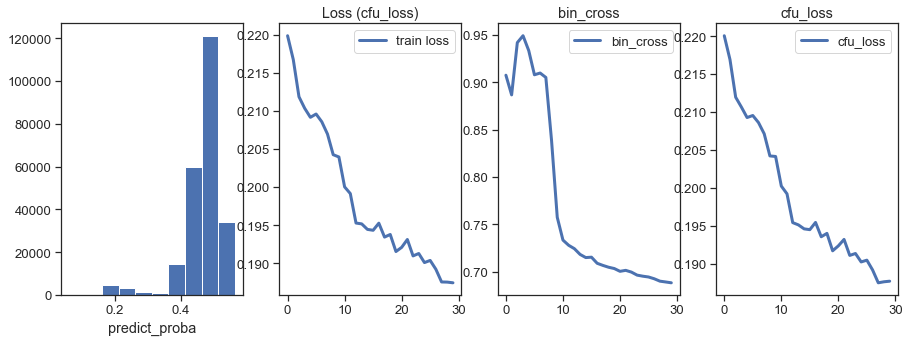

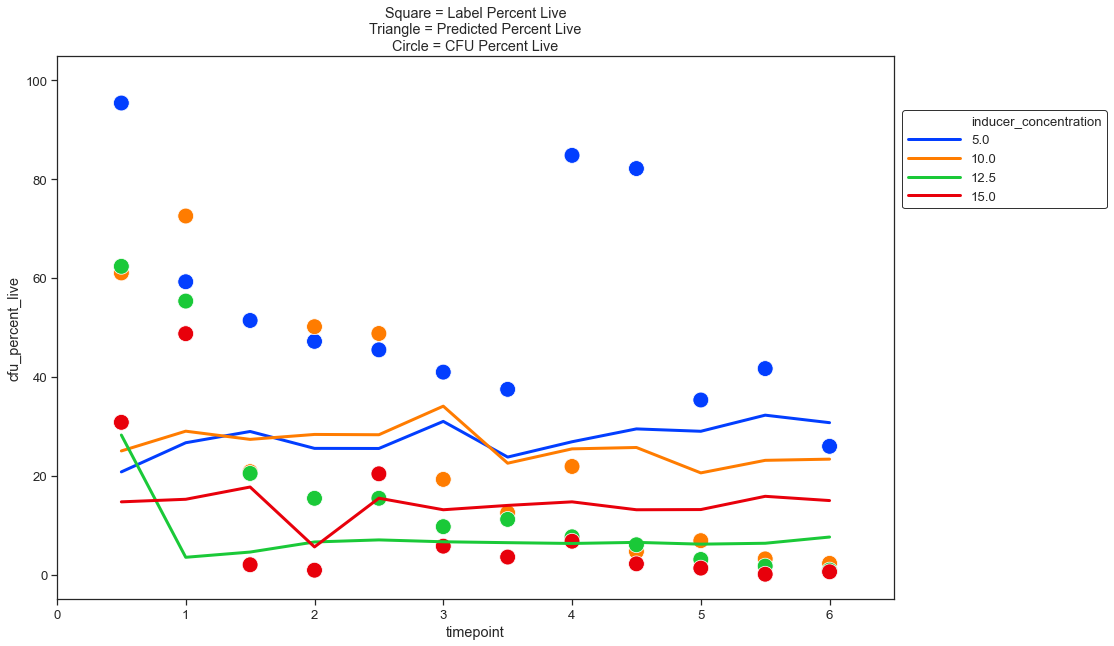

In [33]:
condition_results, preds_and_labels = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = cfu_loss, metrics = [bin_cross, cfu_loss],
                             X = X_all, Y = Y_all, epochs = 30, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

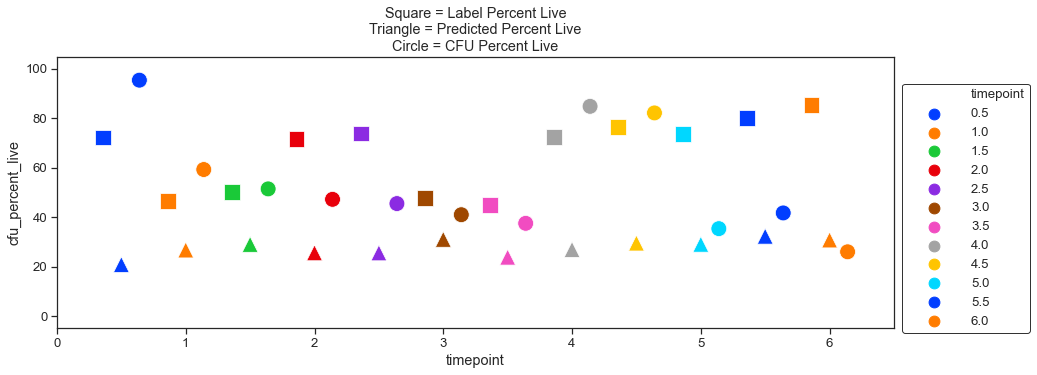

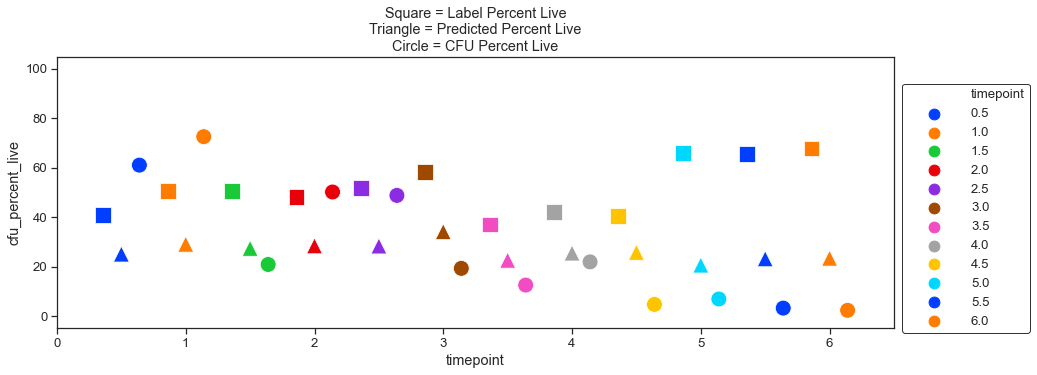

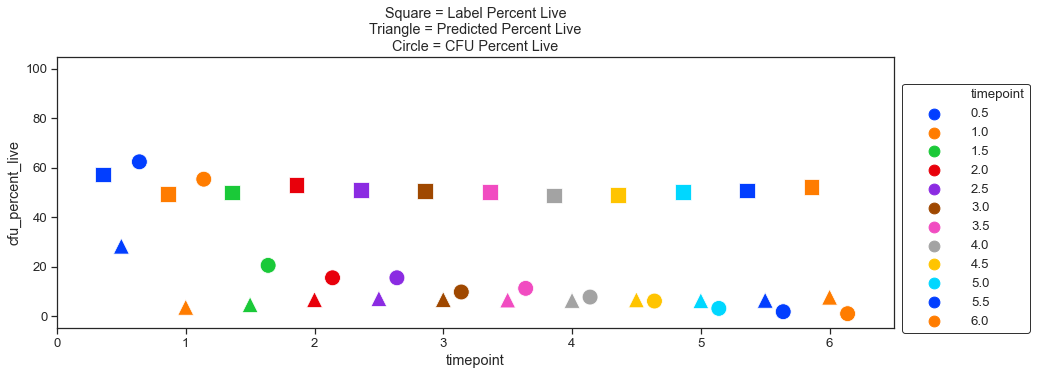

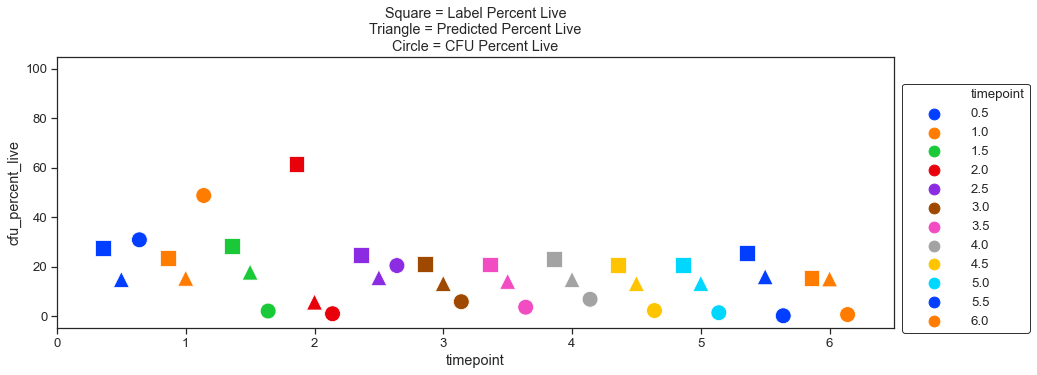

In [34]:
for conc in condition_results[n.inducer_concentration].unique():
    temp = condition_results.loc[condition_results[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="scatter", color_by=n.timepoint, fig_height=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

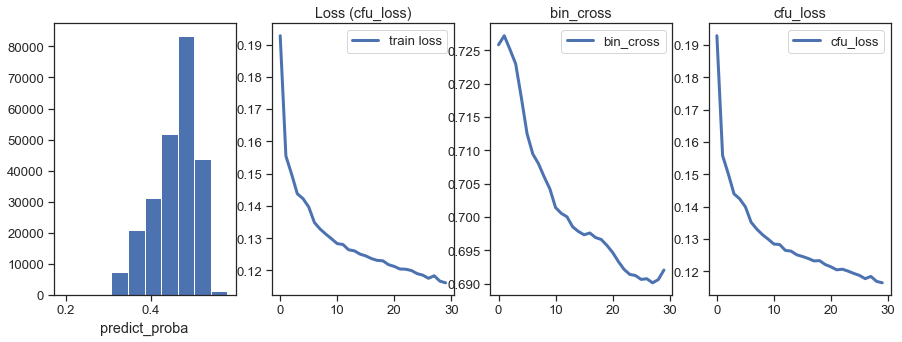

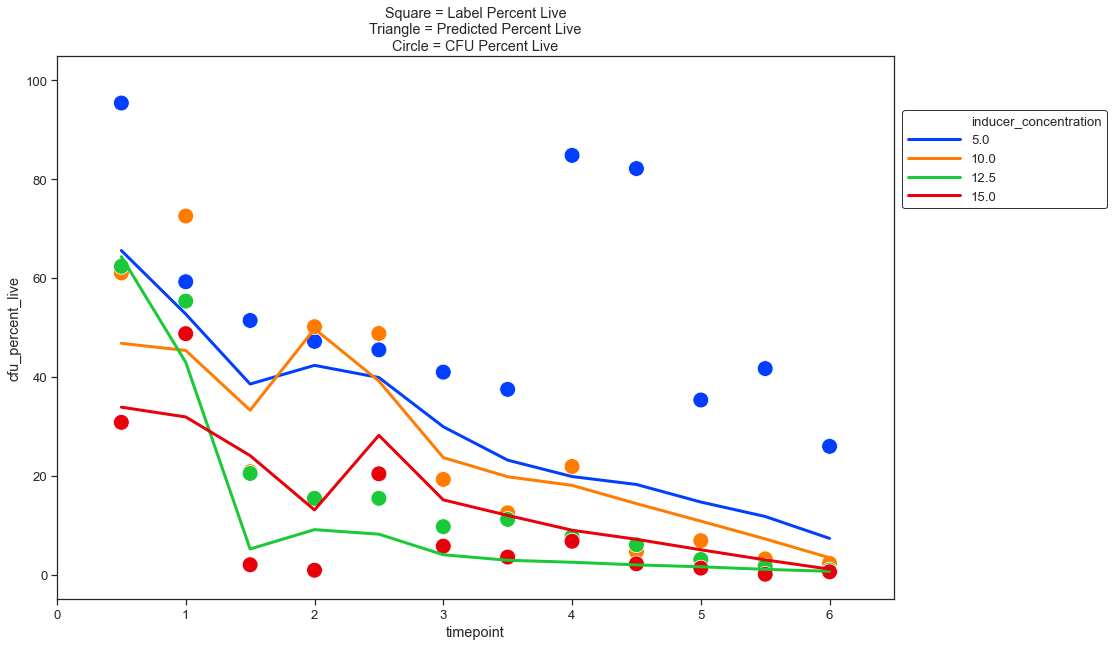

In [39]:
a, b = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = cfu_loss, metrics = [bin_cross, cfu_loss],
                             X = X_special, Y = Y_special, epochs = 30, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

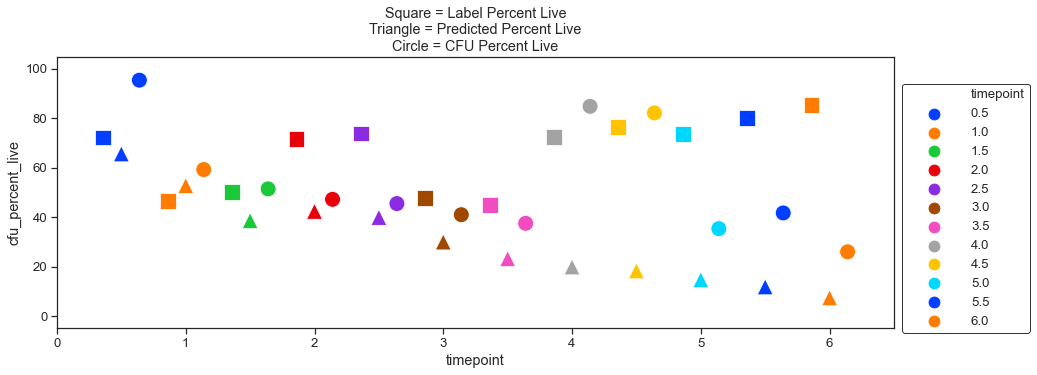

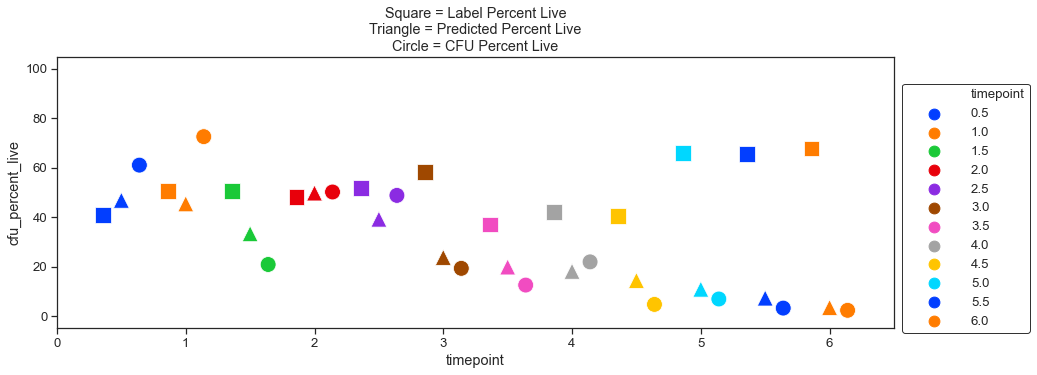

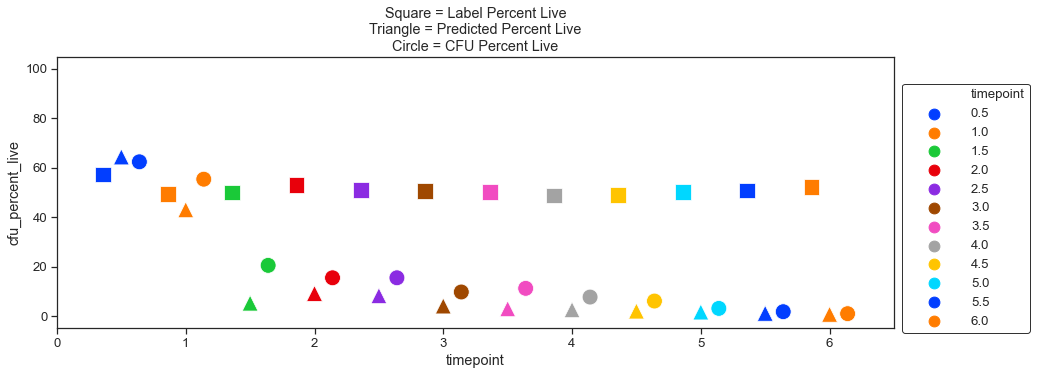

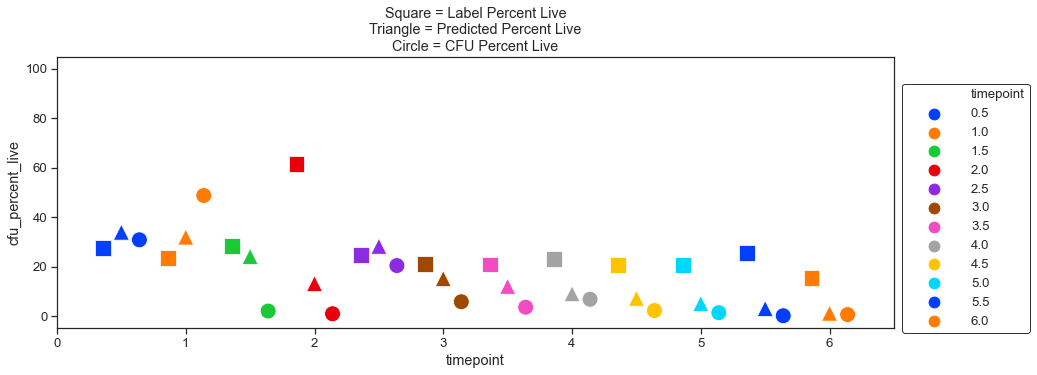

In [40]:
for conc in a[n.inducer_concentration].unique():
    temp = a.loc[a[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="scatter", color_by=n.timepoint, fig_height=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

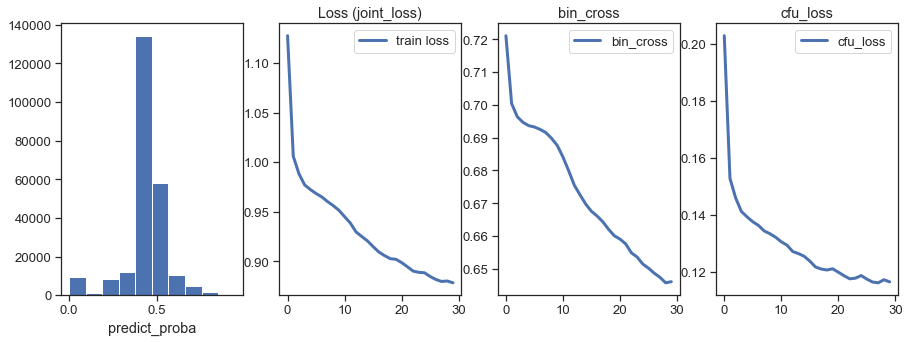

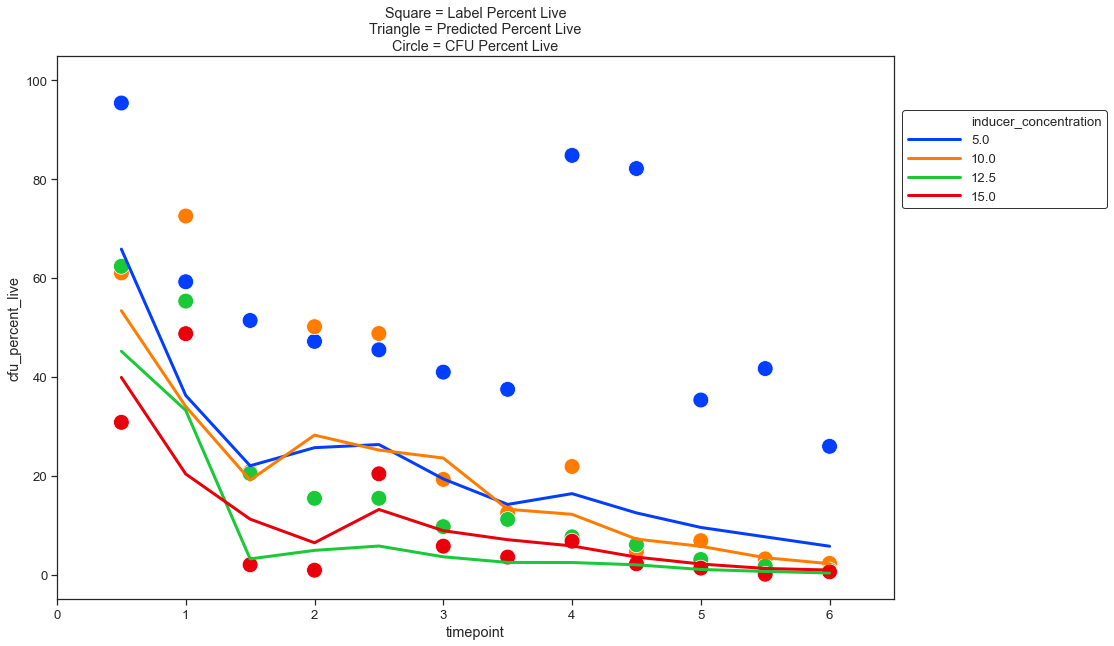

In [41]:
condition_results_2, preds_and_labels_2 = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss],
                             X = X_special, Y = Y_special, epochs = 30, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

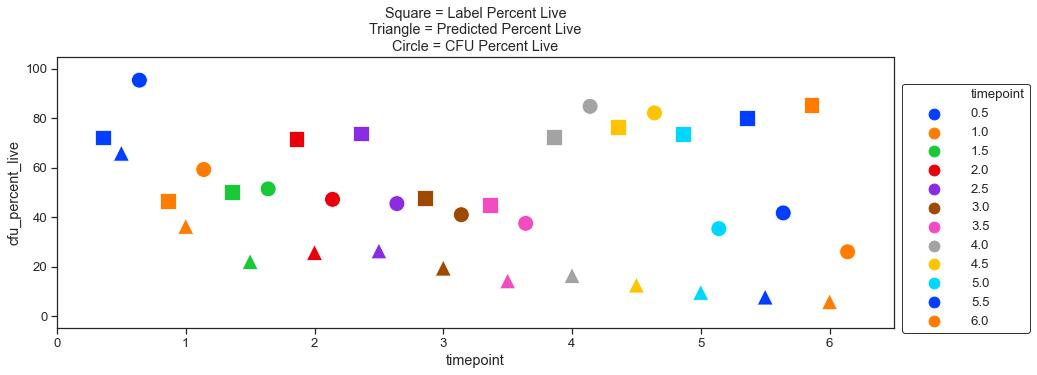

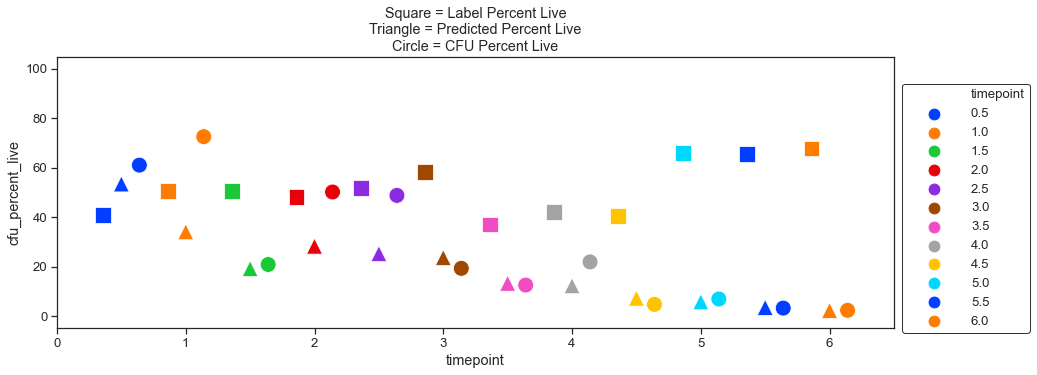

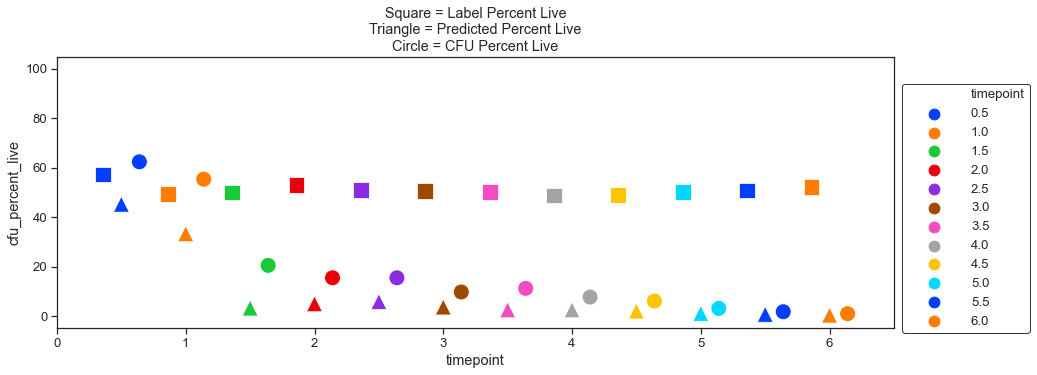

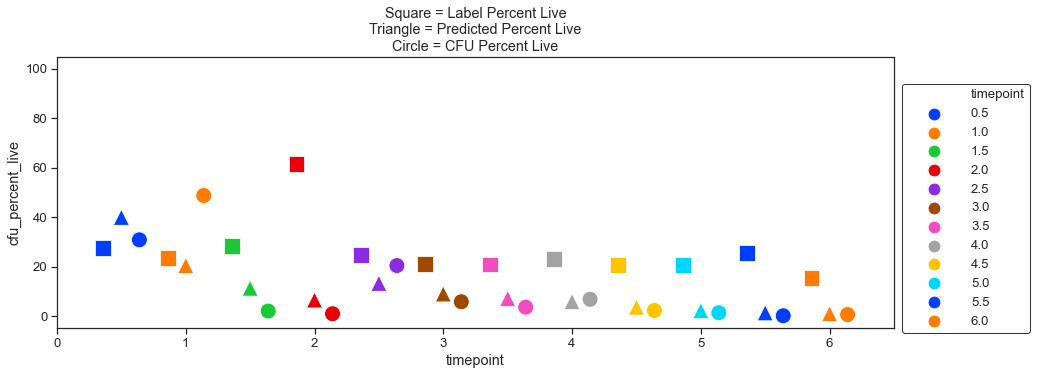

In [42]:
for conc in condition_results_2[n.inducer_concentration].unique():
    temp = condition_results_2.loc[condition_results_2[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="scatter", color_by=n.timepoint, fig_height=5)

Exploring samples that were shifted by CFU loss

In [43]:
preds_and_labels_2

,label,inducer_concentration,timepoint,cfu_percent_live,nn_preds
0,100.0,5.0,0.5,95.423333,100
1,100.0,5.0,0.5,95.423333,100
2,100.0,5.0,0.5,95.423333,100
3,100.0,5.0,0.5,95.423333,100
4,0.0,5.0,0.5,95.423333,0
...,...,...,...,...,...
239995,0.0,15.0,6.0,0.560000,0
239996,0.0,15.0,6.0,0.560000,0
239997,0.0,15.0,6.0,0.560000,0
239998,0.0,15.0,6.0,0.560000,0


In [48]:
concat = pd.concat([X_special, preds_and_labels_2], axis=1)
concat["nn_preds"] = concat["nn_preds"]/100
concat[n.label] = concat[n.label]/100
concat["changed"] = ~(concat["label"] == concat["nn_preds"])
concat["change_type"] = "this_should_be_gone"
concat.loc[(concat["label"] == 0) & (concat["nn_preds"] == 0), "change_type"] = "0_to_0"
concat.loc[(concat["label"] == 1) & (concat["nn_preds"] == 1), "change_type"] = "1_to_1"
concat.loc[(concat["label"] == 0) & (concat["nn_preds"] == 1), "change_type"] = "0_to_1"
concat.loc[(concat["label"] == 1) & (concat["nn_preds"] == 0), "change_type"] = "1_to_0"

concat

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,YL1-A,YL1-H,YL1-W,timepoint,label,inducer_concentration,timepoint,cfu_percent_live,nn_preds,changed,change_type
0,5.89148,5.82349,2.08636,5.99685,5.93833,2.08636,0.00000,3.17026,1.44716,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1
1,5.84730,5.78129,2.10037,5.74649,5.68930,2.06819,3.08814,2.93902,1.94939,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1
2,5.81230,5.76581,2.03743,5.66165,5.61807,2.05308,0.00000,2.55871,1.23045,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1
3,6.01145,5.86360,2.19312,6.02060,5.88844,2.19590,0.00000,2.01703,0.60206,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1
4,5.65131,5.62308,1.97772,5.67979,5.65446,2.00432,2.27416,2.11727,1.23045,0.5,0.0,5.0,0.5,95.423333,0.0,False,0_to_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,5.60251,5.58518,1.94939,5.58904,5.57474,1.99123,2.59106,2.57519,1.68124,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0
239996,5.65934,5.59567,2.01284,5.44806,5.39259,2.01284,2.39620,2.24304,1.43136,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0
239997,5.37106,5.36518,1.95424,5.13850,5.13624,1.95424,2.12710,2.36549,1.50515,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0
239998,5.53336,5.53120,1.93450,5.32755,5.32608,1.94939,2.51322,2.50379,1.62325,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0


In [46]:
concat['nn_percent_live'] = concat.groupby([n.inducer_concentration, n.timepoint])["nn_preds"].transform('mean') * 100

In [57]:
concat["label_probs"] = df_all["label_probs"]
concat

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,YL1-A,YL1-H,YL1-W,timepoint,label,inducer_concentration,timepoint,cfu_percent_live,nn_preds,changed,change_type,label_probs
0,5.89148,5.82349,2.08636,5.99685,5.93833,2.08636,0.00000,3.17026,1.44716,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1,0.904539
1,5.84730,5.78129,2.10037,5.74649,5.68930,2.06819,3.08814,2.93902,1.94939,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1,0.762620
2,5.81230,5.76581,2.03743,5.66165,5.61807,2.05308,0.00000,2.55871,1.23045,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1,0.694297
3,6.01145,5.86360,2.19312,6.02060,5.88844,2.19590,0.00000,2.01703,0.60206,0.5,1.0,5.0,0.5,95.423333,1.0,False,1_to_1,0.671356
4,5.65131,5.62308,1.97772,5.67979,5.65446,2.00432,2.27416,2.11727,1.23045,0.5,0.0,5.0,0.5,95.423333,0.0,False,0_to_0,0.201194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,5.60251,5.58518,1.94939,5.58904,5.57474,1.99123,2.59106,2.57519,1.68124,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0,0.170935
239996,5.65934,5.59567,2.01284,5.44806,5.39259,2.01284,2.39620,2.24304,1.43136,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0,0.332248
239997,5.37106,5.36518,1.95424,5.13850,5.13624,1.95424,2.12710,2.36549,1.50515,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0,0.126908
239998,5.53336,5.53120,1.93450,5.32755,5.32608,1.94939,2.51322,2.50379,1.62325,6.0,0.0,15.0,6.0,0.560000,0.0,False,0_to_0,0.053421


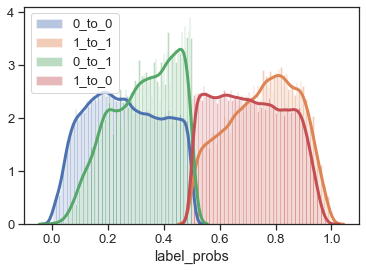

In [58]:
zero_to_zero = concat.loc[concat["change_type"]=="0_to_0", "label_probs"]
one_to_one = concat.loc[concat["change_type"]=="1_to_1", "label_probs"]
zero_to_one = concat.loc[concat["change_type"]=="0_to_1", "label_probs"]
one_to_zero = concat.loc[concat["change_type"]=="1_to_0", "label_probs"]

sns.distplot(zero_to_zero, bins=100, label="0_to_0")
sns.distplot(one_to_one, bins=100, label="1_to_1")
sns.distplot(zero_to_one, bins=100, label="0_to_1")
sns.distplot(one_to_zero, bins=100, label="1_to_0")
plt.legend()

In [ ]:
sns.distplot(zero_to_zero, bins=100, label="0_to_0")
sns.distplot(one_to_one, bins=100, label="1_to_1")
sns.distplot(zero_to_one, bins=100, label="0_to_1")
sns.distplot(one_to_zero, bins=100, label="1_to_0")
plt.legend()
plt.ylim(0, 15)

In [60]:
df_combo = pd.read_csv("models/cfu_neural_network/df_for_testing.csv")

In [61]:
df_combo

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,inducer_concentration,timepoint,label,label_probs,percent_live
0,4.937493,4.852639,1.612784,4.545703,4.432199,1.477121,0.0,0.5,1.0,0.973972,39.67
1,4.881054,4.769717,1.591065,4.593319,4.483273,1.491362,0.0,0.5,1.0,0.903544,39.67
2,5.217273,5.056962,1.716003,5.115637,4.985498,1.662758,0.0,0.5,1.0,0.986633,39.67
3,4.837431,4.795463,1.568202,4.394942,4.333971,1.397940,0.0,0.5,1.0,0.808509,39.67
4,5.224023,4.771183,1.977724,4.895577,4.490436,1.838849,0.0,0.5,1.0,0.930113,39.67
...,...,...,...,...,...,...,...,...,...,...,...
259537,4.086538,3.939769,0.000000,4.006380,3.955592,0.000000,80.0,6.0,0.0,0.008962,0.00
259538,6.020599,5.369036,3.009876,6.020599,6.020599,3.009876,80.0,6.0,0.0,0.359544,0.00
259539,3.429591,3.334454,0.000000,3.146438,2.997386,0.000000,80.0,6.0,0.0,0.000011,0.00
259540,3.640680,3.509337,0.000000,3.005181,2.911690,0.000000,80.0,6.0,0.0,0.000799,0.00


In [62]:
combo_feats = n.morph_cols
combo_feats_t = n.morph_cols + [n.timepoint]

In [64]:
X_combo = df_combo[combo_feats]
Y_combo = df_combo[col_idx.keys()]
X_combo_t = df_combo[combo_feats_t]
print(X_combo.shape)
print(Y_combo.shape)
print(X_combo_t.shape)

(259542, 6)
(259542, 4)
(259542, 7)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

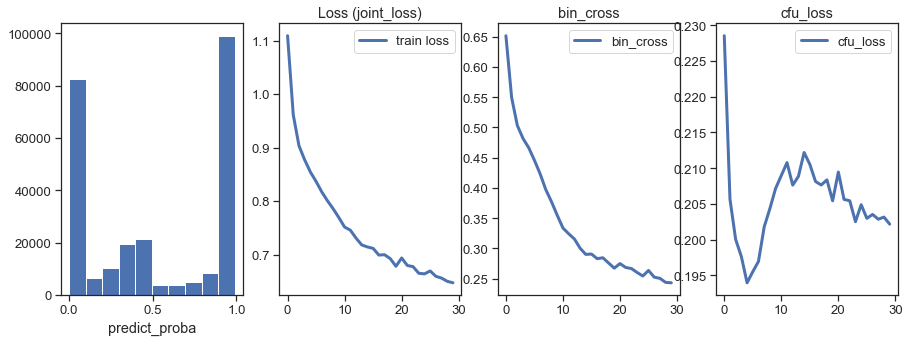

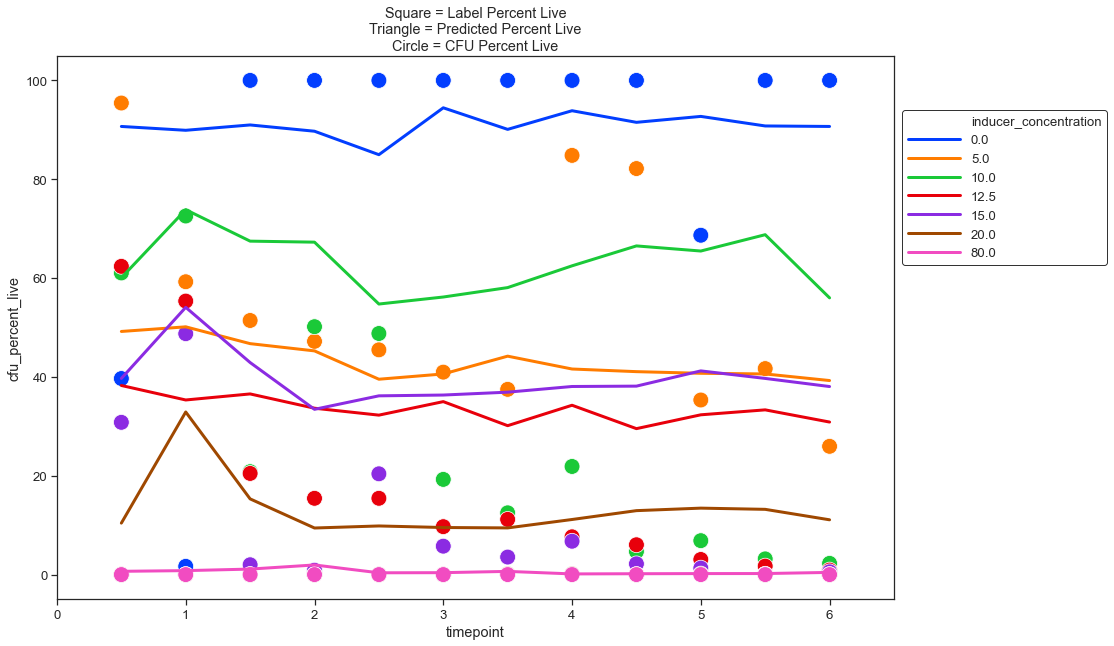

In [67]:
combo_results, combo_preds_and_labels= run_model(model_function=booster_model_v2, lr=0.001,
                                                 loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss],
                                                 X = X_combo, Y = Y_combo, epochs = 30, batch_size = 2048,
                                                 verbose = False, shuffle = True, plot_type="line")

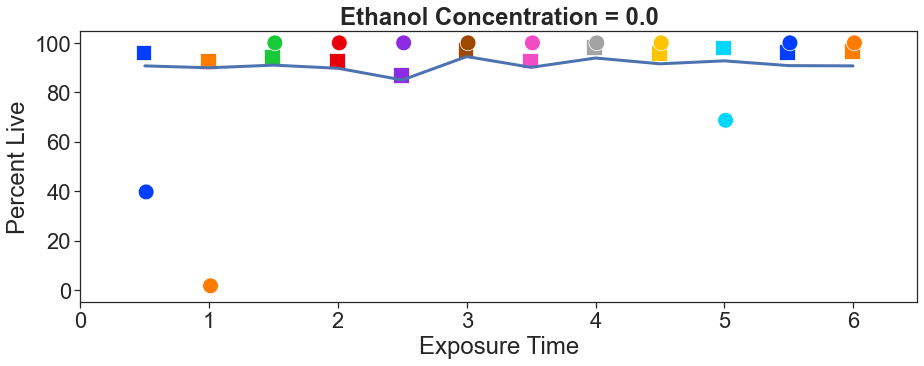

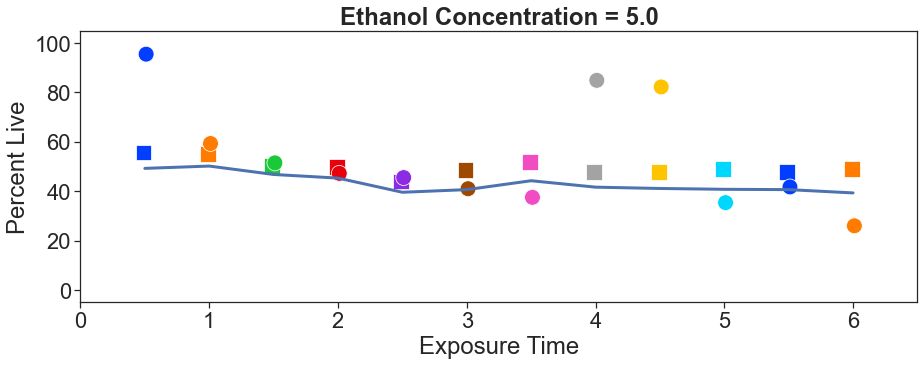

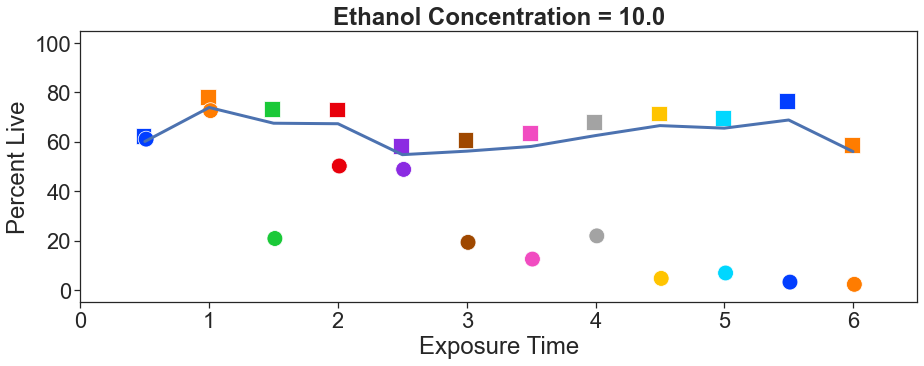

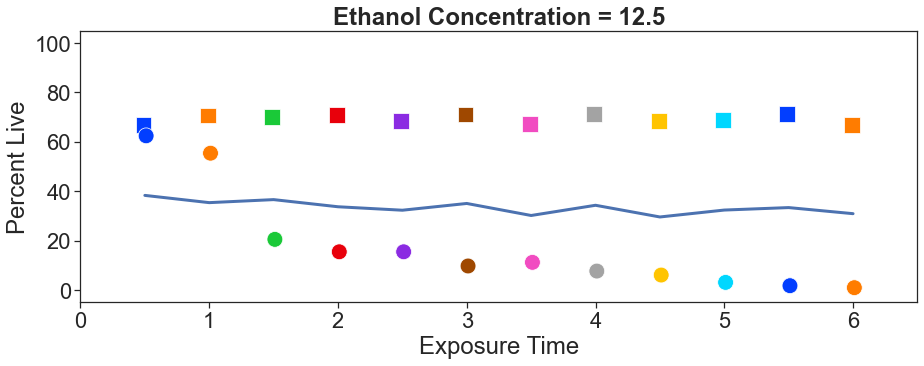

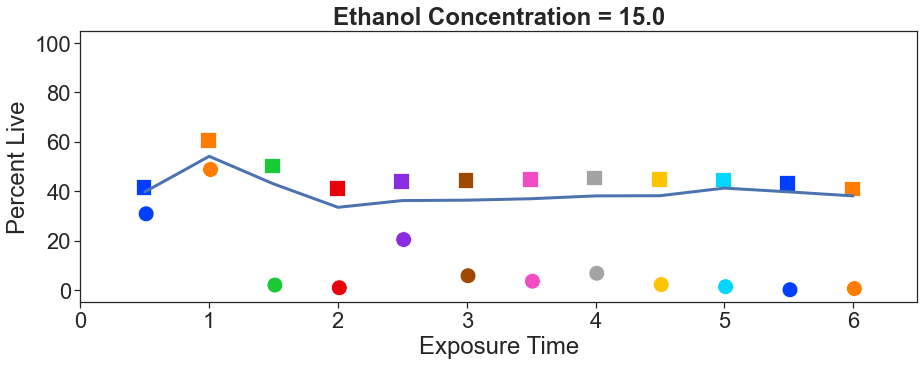

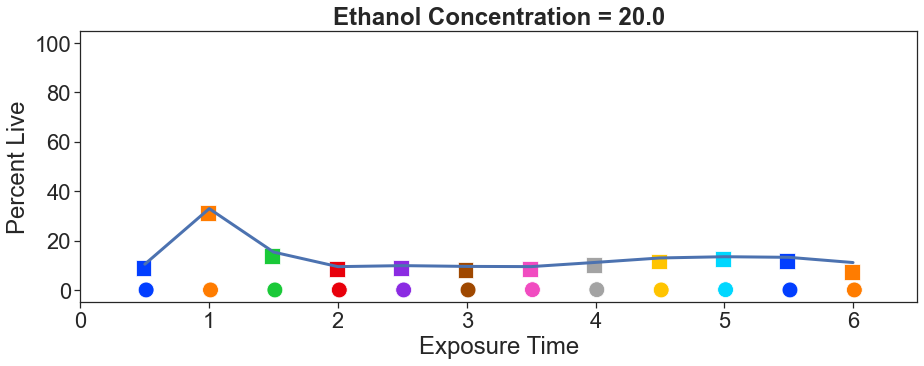

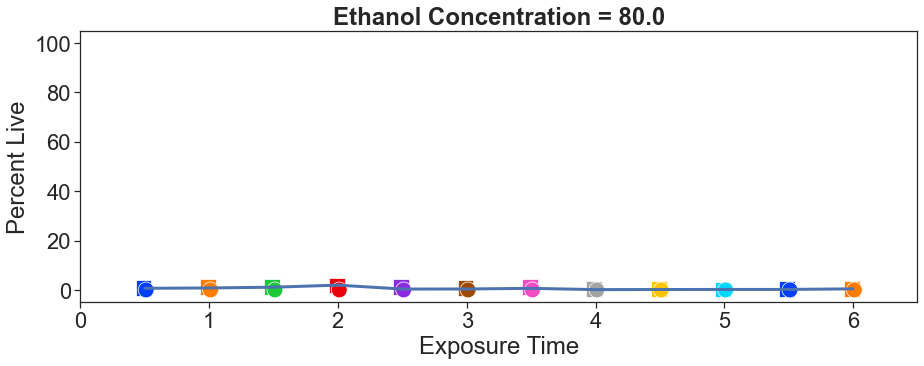

In [109]:
for conc in combo_results[n.inducer_concentration].unique():
    temp = combo_results.loc[combo_results[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="mixed", color_by=n.timepoint, fig_height=5,
                                      title="Ethanol Concentration = {}".format(conc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

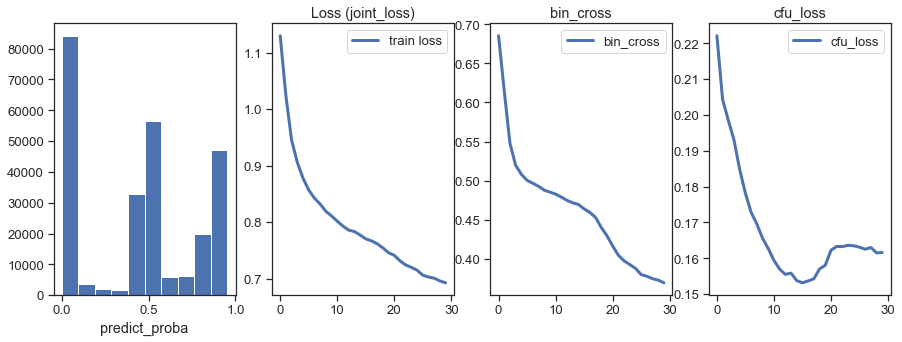

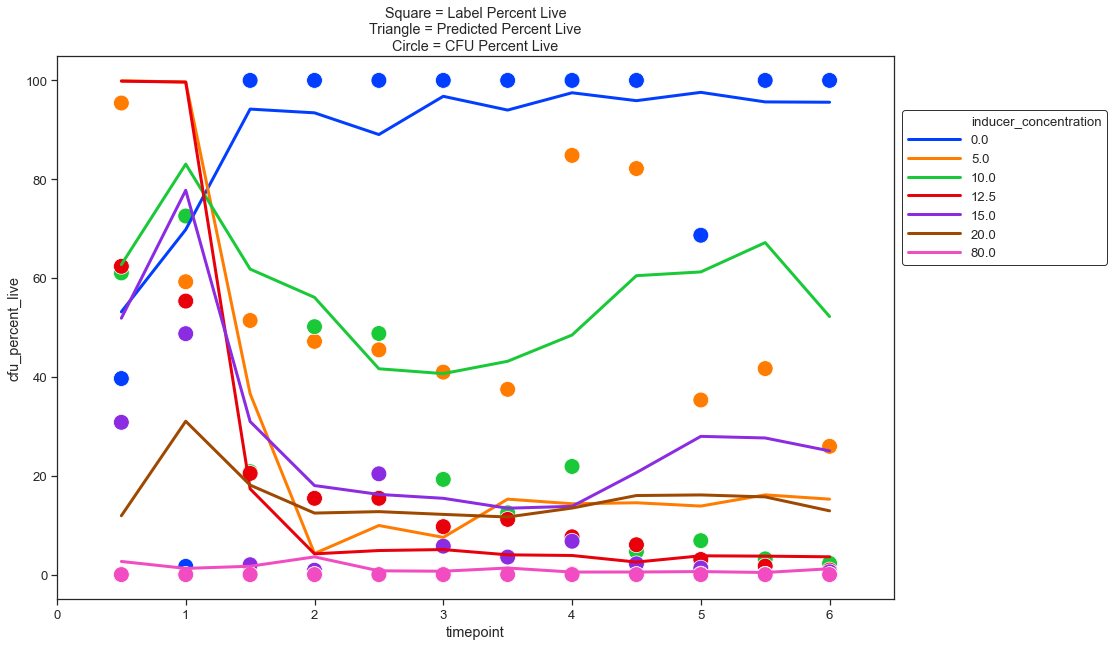

In [68]:
combo_results_t, combo_preds_and_labels_t= run_model(model_function=booster_model_v2, lr=0.001,
                                                 loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss],
                                                 X = X_combo_t, Y = Y_combo, epochs = 30, batch_size = 2048,
                                                 verbose = False, shuffle = True, plot_type="line")

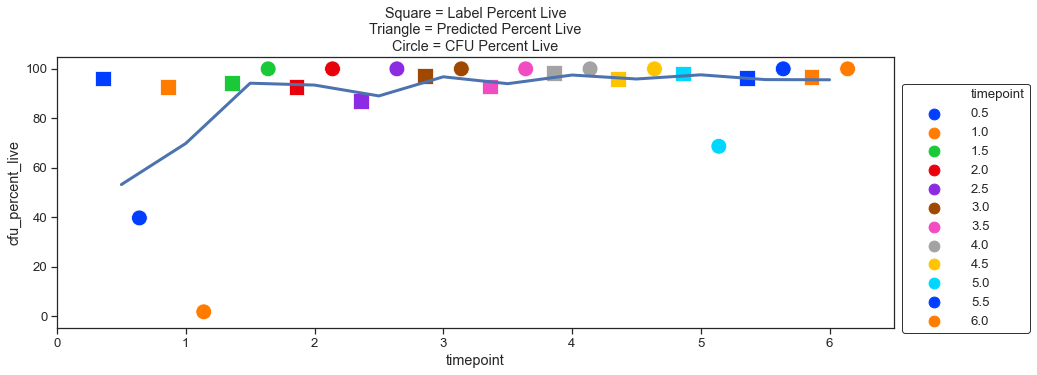

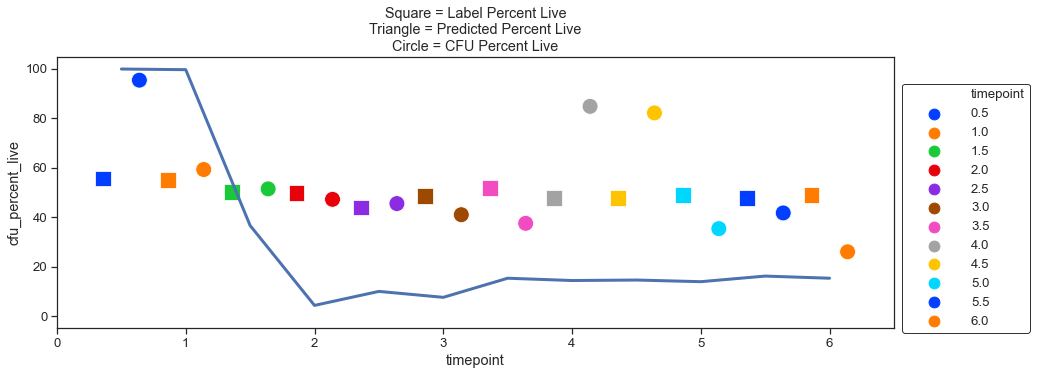

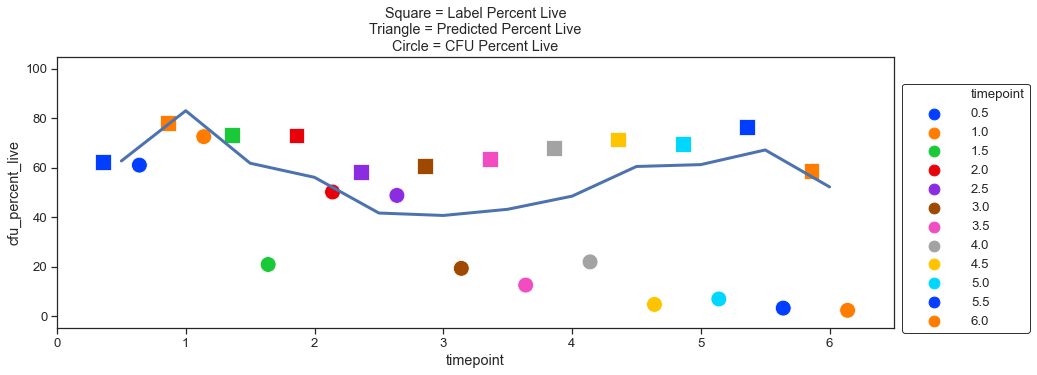

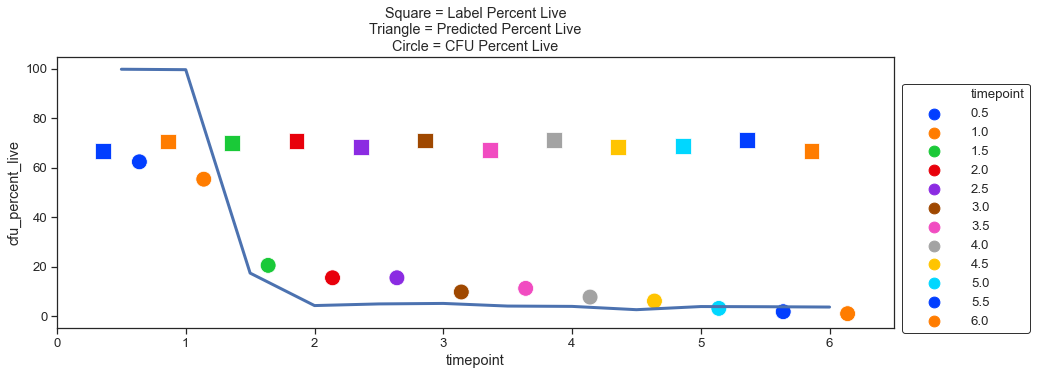

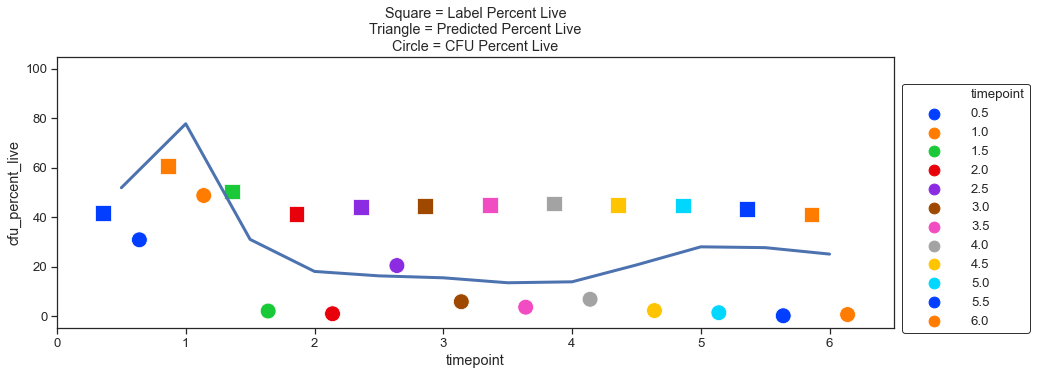

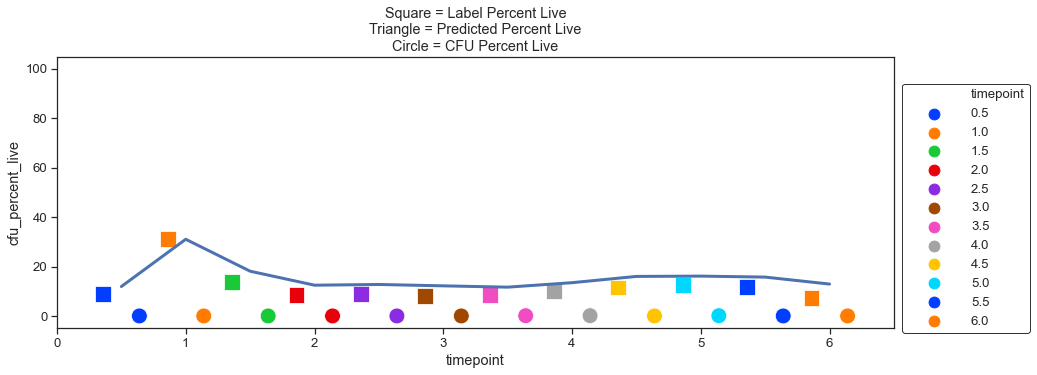

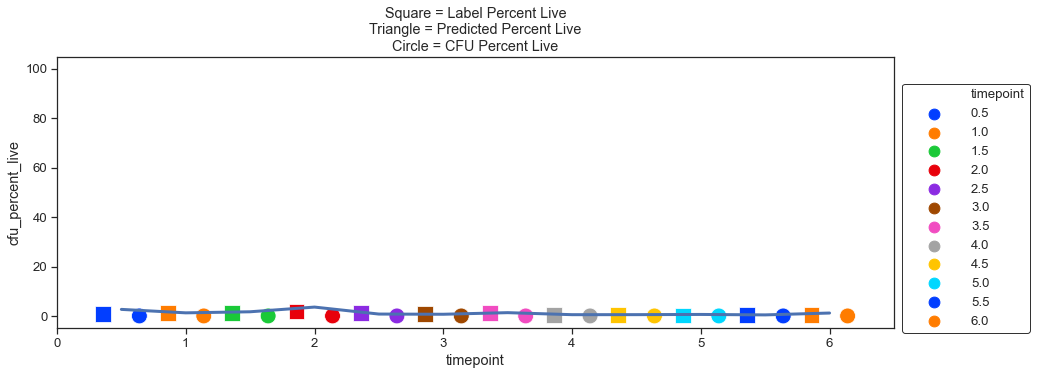

In [88]:
for conc in combo_results_t[n.inducer_concentration].unique():
    temp = combo_results_t.loc[combo_results_t[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="mixed", color_by=n.timepoint, fig_height=5)